Just out of curiousity I decided to start by using the embeddings learnt from node2vec to find communities in the countries dataset. Following cell imports the required packages.

In [1]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import random
import collections

I have decided to pick the embedding set that was based on the BFS settings, which is expected to preserve the local properties. These embeddings have a shape of 200(nodes) by 8(dimensions). So, I will first used PCA to reduce the dimension to 2, so that it can be plotted on a plane surface. 

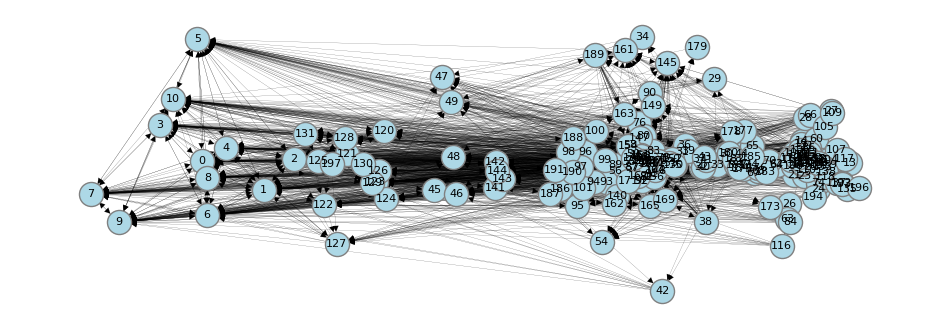

In [2]:
nodes_countries_df = pd.read_csv('data/csv/nodes_countries.csv')
embeddings = torch.load('data/emb/node2vec_countries_bfs.pt')
edges_countries_tensor = torch.load('data/pt/countries_fully_connected_edges.pt').t()
nodes_countries_tensor = edges_countries_tensor.clone().flatten().unique()

emb = embeddings[nodes_countries_tensor].detach().cpu().numpy()
emb2 = PCA(n_components=2).fit_transform(emb)

g = nx.DiGraph()
g.add_nodes_from(
    [(nodes_countries_tensor[i].item(),{"pos": tuple(emb2[i][j].item() for j in range(emb2.shape[1]))}) for i in range(len(emb2))]
)
for edge in edges_countries_tensor.t(): g.add_edge(edge[0].item(),edge[1].item())

plt.figure(figsize=(12,4))
plt.axis('off')
nx.draw_networkx(g,pos = nx.get_node_attributes(g, "pos"),font_size=8,
                 edgecolors='grey',node_color='lightblue',with_labels=True,width=0.1)
plt.show()

In [3]:
# '''
# The above plot clearly shows that some pairs of nodes are more closely embedded than others 
# resulting in some communities. I will use kmeans to cluster the embeddings. The plot below would basically be 
# the same as the plot above, because the reduced embeddings are used as coordinates and we can see how 
# kmeans made the clusters.
# '''

# kmeans = KMeans(n_clusters=5).fit(emb2)
# node_colors = kmeans.labels_

# plt.figure(figsize=(10,5))
# plt.axis('off')
# nx.draw_networkx(
#     g,pos = nx.get_node_attributes(g, "pos"),
#     with_labels=True,node_color=node_colors,font_size=8,edgecolors="black",alpha=0.9,width=0.2#,cmap='rgb'
# )
# plt.show()

In [4]:
for NUM_CLUSTERS in range(1,26):
    for e in [emb2,emb]:
        kmeans = KMeans(n_clusters=NUM_CLUSTERS, n_init=10, random_state=0).fit(e)
        node_colors = kmeans.labels_
        communities = [set() for _ in range(NUM_CLUSTERS)]
        for i in range(len(node_colors)): communities[node_colors[i]].add(i)
        print(f'clusters:{NUM_CLUSTERS}, emb_dim:{e.shape[1]}, modularity: {nx.community.modularity(g,communities):.4f}')

clusters:1, emb_dim:2, modularity: 0.0000
clusters:1, emb_dim:8, modularity: 0.0000
clusters:2, emb_dim:2, modularity: 0.0607
clusters:2, emb_dim:8, modularity: 0.0607
clusters:3, emb_dim:2, modularity: 0.0105
clusters:3, emb_dim:8, modularity: 0.0188
clusters:4, emb_dim:2, modularity: 0.0208
clusters:4, emb_dim:8, modularity: 0.0191
clusters:5, emb_dim:2, modularity: 0.0208
clusters:5, emb_dim:8, modularity: 0.0087
clusters:6, emb_dim:2, modularity: 0.0126
clusters:6, emb_dim:8, modularity: 0.0065
clusters:7, emb_dim:2, modularity: 0.0104
clusters:7, emb_dim:8, modularity: 0.0149
clusters:8, emb_dim:2, modularity: 0.0097
clusters:8, emb_dim:8, modularity: 0.0102
clusters:9, emb_dim:2, modularity: 0.0151
clusters:9, emb_dim:8, modularity: 0.0063
clusters:10, emb_dim:2, modularity: 0.0123
clusters:10, emb_dim:8, modularity: 0.0009
clusters:11, emb_dim:2, modularity: 0.0119
clusters:11, emb_dim:8, modularity: 0.0116
clusters:12, emb_dim:2, modularity: 0.0131
clusters:12, emb_dim:8, modul

I have learnt from here: https://www.youtube.com/watch?v=mJQrtXZT5pw that modularity in the range of 0.3 to 0.7 represents significant community structure. Irrespective of the number of clusters or embeddings (original or reduced), the modularity here is in the range 0.0 to 0.1 (0.0607 to be precise). It might be that the node2vec embeddings that was learnt earliar could not detect communites (under bfs random walk strategy, with p=1 and q=0.5).


Gephi also provided a measure for modularity under community detection, which is based on:

Algorithm:
Vincent D Blondel, Jean-Loup Guillaume, Renaud Lambiotte, Etienne Lefebvre, Fast unfolding of communities in large networks, in Journal of Statistical Mechanics: Theory and Experiment 2008 (10), P1000

Resolution:
R. Lambiotte, J.-C. Delvenne, M. Barahona Laplacian Dynamics and Multiscale Modular Structure in Networks 2009

This is basically the famous Louvain method for community detection (https://en.wikipedia.org/wiki/Louvain_method). Networkx provides an implementation for this. 

In [5]:
# communities = nx.community.greedy_modularity_communities(g)
communities = nx.community.louvain_communities(g, weight=None)
print(f'modularity score: {nx.community.modularity(g,communities):.4f}');print()
for i in range(len(communities)):print(f'{i}:{[nodes_countries_df['name'].to_list()[j] for j in list(communities[i])]}');print()

modularity score: 0.4680

0:['AFGHANISTAN', 'ALBANIA', 'ALGERIA', 'ANDORRA', 'ANGOLA', 'ANTIGUA AND BARBUDA', 'ARGENTINA', 'PANAMA', 'AUSTRALIA', 'AUSTRIA', 'ARMENIA', 'PAPUA NEW GUINEA', 'AZERBAIJAN', 'QATAR', 'ROMANIA', 'RUSSIA', 'RWANDA', 'BOLIVIA', 'BOSNIA AND HERZEGOVINA', 'BOTSWANA', 'BULGARIA', 'BURMA', 'CAMBODIA', 'CANADA', 'CHINA', 'COLOMBIA', 'COSTA RICA', 'CROATIA', 'CUBA', 'TANZANIA', 'THE GAMBIA', 'TONGA', 'TUNISIA', 'UGANDA', 'GEORGIA', 'GHANA', 'VENEZUELA', 'GRENADA', 'GUATEMALA', 'GUINEA', 'ZAMBIA', 'GUYANA', 'JAMAICA', 'KENYA', 'LATVIA', 'LIBERIA', 'LIBYA', 'LITHUANIA', 'MACEDONIA', 'MALAYSIA', 'MALTA', 'MAURITANIA', 'MICRONESIA', 'MOLDOVA', 'MONGOLIA']

1:['VANUATU', 'GREECE', 'PALAU', 'GUINEA-BISSAU', 'ZIMBABWE', 'PERU', 'REPUBLIC OF CONGO', 'BELIZE', 'EQUATORIAL GUINEA', 'CAPE VERDE', 'CENTRAL AFRICAN REPUBLIC', 'CHILE', 'TUVALU', "COTE D'IVOIRE", 'CZECH REPUBLIC', 'EAST TIMOR', 'ECUADOR', 'EGYPT', 'EL SALVADOR', 'ENGLAND', 'MOZAMBIQUE', 'ERITREA', 'ESTONIA', 'ETHIO

Below is a screenshot from gephi that is the result of the lovain community detection algorithm. This is a greedy algorithm and it depends on the ordering of the nodes. The ordering of the nodes is shuffled before running the algorithm so the results above and below may not be identical.

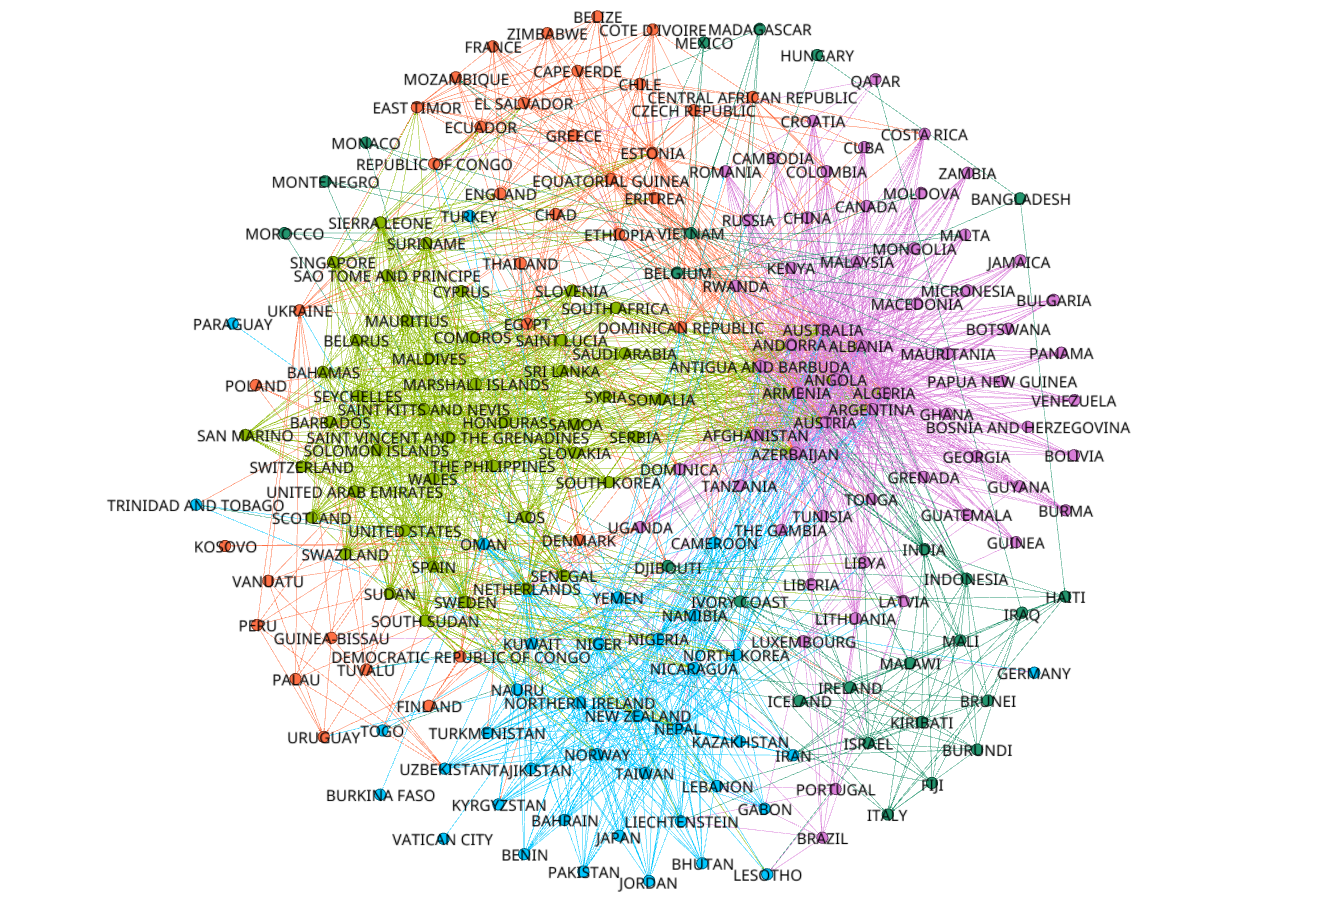

In [6]:
from IPython.display import Image

Image(filename="data/png/screenshot_gephi_countries_modularity.png", width=700)

The modularity report from gephi is saved in data/reports and the screenshot for the same is below.

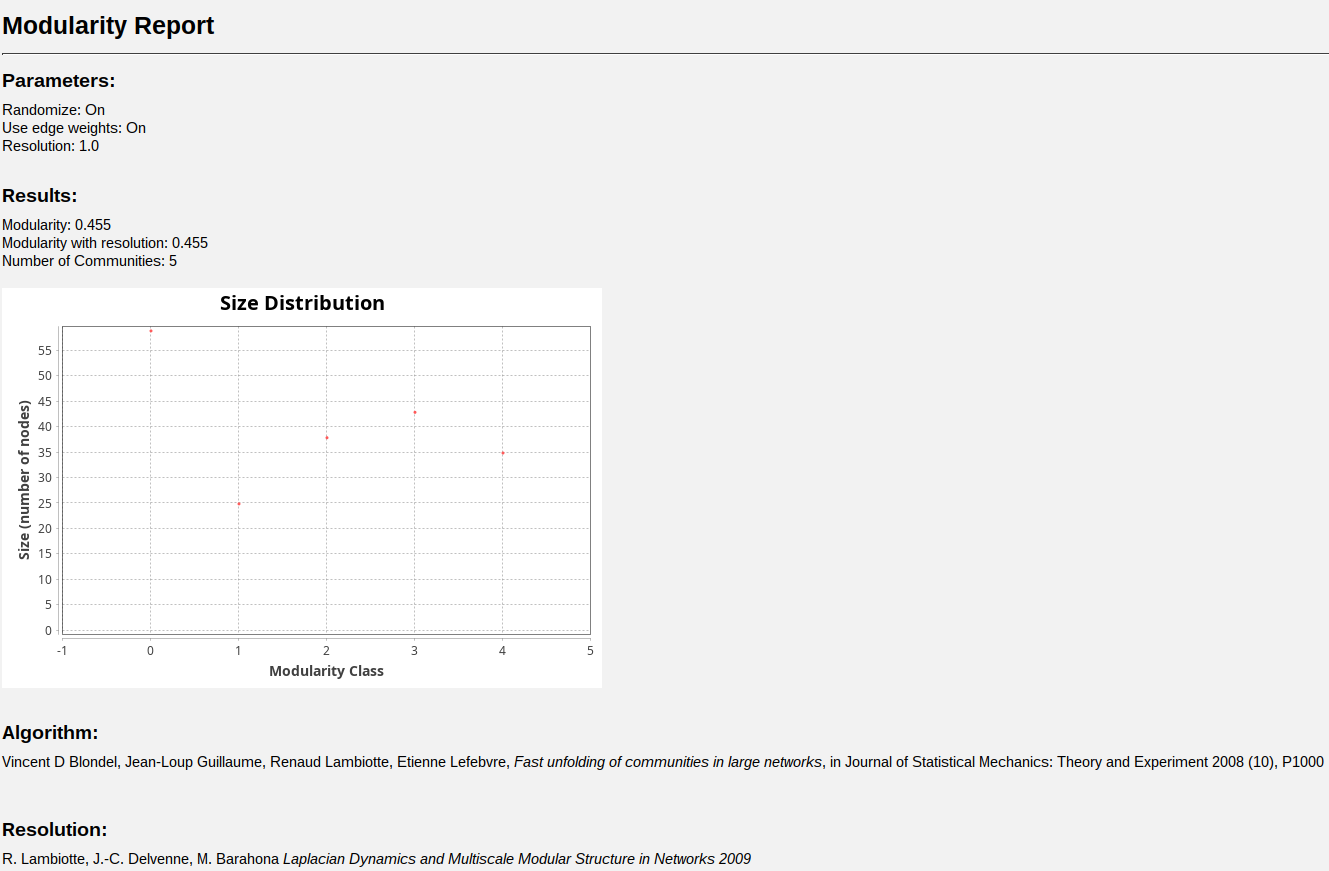

In [5]:
from IPython.display import Image

Image(filename="data/png/screenshot_gephi_countries_modularity_report.png", width=700)